#### ftns

In [1]:
import numpy as np
import scipy as sp

from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt


def subps(nrows,ncols,rowsz=3,colsz=4,axlist=False):

    f,axes = plt.subplots(nrows,ncols,figsize=(ncols*colsz,nrows*rowsz))
    if axlist and ncols*nrows == 1:
        axes = [axes]
    return f,axes

def get_per_worm_data(data, trace_type='norm_traces', smooth_sig=1.5, classes_to_use=[0,1,2,3], N_WORMS=21):
    
    
    neuron_names = []
    neuron_classes = []
    neuron_pos = []
    
    LR_pairs = {}
    
    trace_len = int(data[trace_type][0][0][0][0].shape[1])

    worm_data = {wormi:[] for wormi in range(N_WORMS)}
    worm_xyz = {wormi:[] for wormi in range(N_WORMS)}

    N_NEURON_TYPES = data[trace_type].shape[0]
    #fill the array with the data
    for typi in range(N_NEURON_TYPES): #neuron type idx
        name = data['neurons'][typi][0][0]
        nclass = neuron_class_is_dict[name]
        if nclass not in classes_to_use:
            continue
        for left_side in [1,0]:
            if not np.any(np.isnan(data['is_L'][typi][0][0])): #no NaNs means this neuron type has both sides
                #find reps for the current side
                side_reps = np.flatnonzero(data['is_L'][typi][0][0] == left_side)
                #add side to neuron name
                neuron_names.append(name+('L' if left_side else 'R'))
                neuron_classes.append(nclass)
                LR_pairs[name+('L' if left_side else 'R')] = name+('R' if left_side else 'L')
                
            else:
                if left_side == 1:
                    side_reps = np.arange(N_WORMS)
                    name = data['neurons'][typi][0][0]
                    neuron_names.append(name)
                    neuron_classes.append(nclass)
                else: 
                    continue #(skip what's below since there is only one side)
                    
            assert len(side_reps) == N_WORMS

            for wormi,repi in enumerate(side_reps):
                trace = data[trace_type][typi][0][0][repi].ravel()
                if len(trace) == 0:
                    trace = np.zeros(trace_len)
                    xyz_trace = np.zeros((trace_len,3))
                else:
                    xyz_trace = data["positions"][typi][0][0][repi] # ~960-by-3 array
                    try:
                        assert xyz_trace.shape[0] == trace.size
                    except:
                        print(typi,wormi,repi)
                        raise ValueError
                    if smooth_sig > 0:
                        trace = gaussian_filter1d(trace,smooth_sig)

                worm_data[wormi].append(trace)
                
                
                worm_xyz[wormi].append(xyz_trace)

    for wormi in range(N_WORMS):
        #trim so all have the same len
        min_len = min(map(lambda x: x.size, worm_data[wormi]))
        worm_data[wormi] = np.array([worm_data[wormi][xi][:min_len] for xi in range(len(worm_data[wormi]))])
        worm_xyz[wormi] = np.array([worm_xyz[wormi][xi][:min_len] for xi in range(len(worm_xyz[wormi]))])
    return worm_data, neuron_names, neuron_classes, worm_xyz, LR_pairs

def remove_LR_pairs(W, exceptions = []):
    """ For each neuron pair Left/Right, substitute it by the one with the highest affinity in each edge """
    N = W.shape[0]
    assert N == len(neuron_names)
    
    log_neurons_used = {}
    
    cc = 0
    Rs = []
    ni = 0
    lrW = np.zeros_like(W)
    while ni < N:
        nnamei = neuron_names[ni]

        nis = [ni] #options for neuron i (possibly include L & R)
        if nnamei not in exceptions and nnamei[-1] == 'L' and nnamei in LR_pairs:
            nis.append(ni+1)
            
        nj = nis[-1]+1 #next neuron in the list
        while nj < N:
            njs = [nj] #options for the neuron j
            nnamej = neuron_names[nj]
            if nnamej not in exceptions and nnamej[-1] == 'L' and nnamej in LR_pairs:
                njs.append(nj+1)
            
            wijs = W[nis][:,njs] #look up affs between all possible pairs: (Li,Lj), (Li,Rj), (Ri,Lj), (Ri,Rj)
            assert wijs.shape == (len(nis),len(njs))
            wij = wijs.max() #pick the max
            lrW[ni,nj] = wij
            lrW[nj,ni] = wij
            if wij > 0:
                amax_ni, amax_nj = wijs.argmax() // wijs.shape[1],  wijs.argmax() % wijs.shape[1]
                log_neurons_used[(ni,nj)] = (neuron_names[nis[amax_ni]], neuron_names[njs[amax_nj]],)

            nj = njs[-1]+1
        ni = nis[-1]+1
    
    return lrW, log_neurons_used


def plotMultipleTraces(nnames, wormis, alphas=None, smooth_sig=None, plot_positions=True):
    
    f,axes = subps(len(wormis),1,1.75,20,axlist=1)
    cmaps = ['Reds','Blues','Greens','Greys','Purples','Oranges']
    colors = ['r','b','g','gray','purple','orange']
    for wi,wormi in enumerate(wormis):
        ax = axes[wi]
        ax.set_title(f'orig. traces, re-scaled - worm {wormi}')
        
        ax.set_xlabel('time')
        for stimi,(s,e) in enumerate(STIM_TIMES):
            ax.axvline(s,color='m',ls='--')
            ax.axvline(e,color='m',ls='--')
            ax.text((s+e)/2,1,STIM_NAMES[head_data['stims'][wormi][stimi]-1])
            
            
        for ii,nname in enumerate(nnames):
            
            ni = neuron_names.index(nname)
            orig_trace_i = raw_wormXs[wormi][ni].copy()
            
            orig_trace_i -= orig_trace_i.min()
            if orig_trace_i.max() > 0:
                orig_trace_i /= orig_trace_i.max()
                
            if smooth_sig is not None and smooth_sig > 0:
                trace_i = gaussian_filter1d(orig_trace_i,smooth_sig)
            else:
                trace_i = orig_trace_i
            
            x = actual_times
            y = trace_i
            
            if alphas is not None:

                points = np.vstack((x, y)).T.reshape(-1, 1, 2)
                segments = np.hstack((points[:-1], points[1:]))
                lc = LineCollection(segments, array=alphas, cmap=cmaps[ii], lw=3)#, label=nname)
                ax.scatter([0],[1],c=colors[ii],label=nname)
                line = ax.add_collection(lc)
                ax.autoscale()            
            else:
                ax.plot(actual_times,trace_i,label=nname)
        ax.legend(bbox_to_anchor=(1,1))


    f.tight_layout()
    plt.show()


def plotAffinityComputation(nnames, wormi, smooth_sig, thresh = 0.1, norm_indiv_bumps = False, scaled_simis=True, 
                   nonneg=True, debug_simis = False, save_figs=None, neuron_colors=['b', 'orange']):
    
    assert len(nnames) == 2
    
    neuron_iso_bumps = []
    neuron_comb_bumps = []
    neuron_bump_x0x1s = []
    orig_traces = []
    smooth_traces = []
    xs = actual_times
    tlen = len(xs)
    
    #NEW
    neuron_scld_comb_bumps = []
    neuron_trace_fracs = []
    
    for nname in nnames:
        naxes = 3
        f,axes = subps(naxes,1,1.5,20,axlist=1)


        ni = neuron_names.index(nname)
        #original trace
        ax = axes[0]
        ax.set_title(f'neuron {nname}, worm {wormi}')
        
        orig_trace_i = raw_wormXs[wormi][ni].copy()
        
        orig_trace_i -= orig_trace_i.min()
        if orig_trace_i.max() > 0:
            orig_trace_i /= orig_trace_i.max()
        orig_traces.append(orig_trace_i)
        
        ax.plot(xs,orig_trace_i,label='orig. trace, re-scaled')

        #compute derivs
        trace_i = gaussian_filter1d(orig_trace_i,smooth_sig)
        smooth_traces.append(trace_i)
        ax.plot(xs,trace_i,label=f'smoothed, sig={smooth_sig}')


        ax = axes[1]
        g_i = np.gradient(trace_i)
        g_i_absmax = abs(g_i).max()
        if g_i_absmax > 0:
            g_i /= g_i_absmax
        ax.plot(xs,g_i,c='k',label='1st deriv')


        zeroxs = np.r_[0,np.flatnonzero(np.sign(g_i[1:] * g_i[:-1]) < 0) + 1,len(g_i)]
        for zi,zerox in enumerate(zeroxs):
            ax.axvline(xs[min(zerox,len(xs)-1)],c='b',label='bump' if zi == 0 else None)

        #find all bumps withtin zeroxs
        bumps_x0x1s = [(zeroxs[i-1],zeroxs[i]) for i in range(1,len(zeroxs))]
        #filter bumps
        
        bumps_x0x1s = [(x0,x1) for x0,x1 in bumps_x0x1s if np.abs(g_i[x0:x1]).max() > thresh]
        neuron_bump_x0x1s.append(bumps_x0x1s)
        for bi,(x0,x1) in enumerate(bumps_x0x1s):
            ax.axvline(xs[x0],c='orange',label='signif. bump' if bi == 0 else None)
            ax.axvline(xs[min(x1,len(xs)-1)],c='orange')

        ax = axes[2]
        all_isolated_bumps = []
        combined_bumps = np.zeros_like(g_i)
        scld_combined_bumps = np.zeros_like(g_i)
        max_delta_trace = 0
        trace_fracs = np.zeros(len(bumps_x0x1s))
        for bi,(x0,x1) in enumerate(bumps_x0x1s):
            bump = (g_i[x0:x1])
#             bump /= bump.max()
            ax.plot(xs[x0:x1],bump,'k-')
    
            isolated_bump = np.zeros_like(g_i)
            isolated_bump[x0:x1] = (g_i[x0:x1])
            all_isolated_bumps.append(isolated_bump)
            
            combined_bumps += isolated_bump
            
            delta_trace = abs(trace_i[x0] - trace_i[min(tlen-1,x1)])
            trace_fracs[bi] = delta_trace
            scld_combined_bumps += isolated_bump/max(abs(isolated_bump)) * delta_trace
            max_delta_trace = max(delta_trace, max_delta_trace)
            
        scld_combined_bumps /= max_delta_trace
        trace_fracs /= max_delta_trace
            
        ax.plot(xs,combined_bumps,'k-',lw=.5,zorder=0,label='bumps')
        neuron_iso_bumps.append(all_isolated_bumps)
        neuron_comb_bumps.append(combined_bumps)
        #NEW
        neuron_scld_comb_bumps.append(scld_combined_bumps)
        neuron_trace_fracs.append(trace_fracs)

        for ax in axes:
            ax.legend(loc='upper right')
            ax.axhline(ls=':',c='k')
        f.tight_layout()
        plt.show()

    naxes = 2
    f,axes = subps(naxes,1,2,20,axlist=1)
    ax = axes[0]
    ax.set_title('comparing smooth traces')
    for i,(nname,trace) in enumerate(zip(nnames,smooth_traces)):
        ax.plot(xs,trace,c=neuron_colors[i],lw=2.5,label=nname)
#     ax = axes[1]
#     ax.set_title('comparing bumps')
#     for i,(nname,combined_bumps) in enumerate(zip(nnames,neuron_comb_bumps)):
#         ax.plot(xs,combined_bumps,c=neuron_colors[i],lw=2,label=f'{nname}')# - {len(neuron_iso_bumps[i])} bumps')
    ax = axes[1]
    ax.set_title('comparing scld bumps')
    for i,(nname,combined_bumps) in enumerate(zip(nnames,neuron_scld_comb_bumps)):
        ax.plot(xs,combined_bumps,c=neuron_colors[i],ls='-.',lw=2.5,label=f'{nname}')# - {len(neuron_iso_bumps[i])} bumps')
    
    for ax in axes:
        ax.legend(loc='upper right',fontsize=12)
        ax.axhline(ls=':',c='k')
        ax.set_xlabel('time (s)',size=12)
    f.tight_layout()
    if save_figs:
        plt.savefig(save_figs + 'bumps.pdf', transparent=True, bbox_inches='tight')
    plt.show() 

    
    bumps_i, bumps_j = neuron_bump_x0x1s
    #for each x position, get corresponding bump index
    bi = 0; bj = 0

    simi_inst = np.zeros_like(xs)
    simi_max = np.zeros_like(xs)
    simi_both = np.zeros_like(xs)
    #NEW
    simi_maxnew = np.zeros_like(xs)
    
    if len(bumps_i) > 0 and len(bumps_j) > 0:
        
        while bi < len(bumps_i) or bj < len(bumps_j): #while any of the two traces has bumps left

            #get current bump info for each neuron (dont update if already at the last bump)
            if bi < len(bumps_i):
                x0i, x1i = bumps_i[bi]
                bumpi = neuron_iso_bumps[0][bi].copy()
                signi = np.sign(bumpi[x0i+1])
                bumpi = abs(bumpi)
                scli = bumpi.max()
                bumpi /= scli
                #NEW
                trace_fraci = neuron_trace_fracs[0][bi]
            if bj < len(bumps_j):
                x0j, x1j = bumps_j[bj]
                bumpj = neuron_iso_bumps[1][bj].copy()
                signj = np.sign(bumpj[x0j+1])
                bumpj = abs(bumpj)
                sclj = bumpj.max()
                bumpj /= sclj
                #NEW
                trace_fracj = neuron_trace_fracs[1][bj]

            if (x0i <= x0j and x1i > x0j) or (x0j <= x0i and x1j > x0i): #if no intersection, simi is 0, so can skip



                areai = bumpi.sum()
                areaj = bumpj.sum()

                if scaled_simis:
                    scl = np.sqrt(scli * sclj)
                    sclnew = min(trace_fraci, trace_fracj)
                else:
                    scl = 1
                    
                if not nonneg:
                    scl *= signi * signj
                    sclnew *= signi * signj
                    
                i_above = np.flatnonzero(bumpi >= bumpj)
                j_above = np.flatnonzero(bumpj > bumpi)
                    
                
                
                
                #distance wrt i
                diff_i = sum(bumpi[i_above] - bumpj[i_above])
                #distance wrt j
                diff_j = sum(bumpj[j_above] - bumpi[j_above])
                
                #METHOD 'MAX'
                simi_i = 1 - diff_i/areai
                simi_j = 1 - diff_j/areaj
                
                simi_ij = max(simi_i, simi_j) * scl
                siminew_ij = max(simi_i, simi_j) * sclnew

                

                #assign similarity to the entirety of the most restrictive bump (or starting from pos? 
                # or intersection? max(xi0,xj0) and min(xi1,xj1)
                simi_max[max(x0i,x0j):min(x1i,x1j)] = simi_ij
                simi_maxnew[max(x0i,x0j):min(x1i,x1j)] = siminew_ij
                
                #METHOD 'INSTANT'
                simi_inst[max(x0i,x0j):min(x1i,x1j)] = simi_ij * np.min([bumpi[max(x0i,x0j):min(x1i,x1j)], 
                                                                         bumpj[max(x0i,x0j):min(x1i,x1j)]],0)
                
                
                #METHOD 'BOTH'
                simi_ij = scl * ( 1 - (diff_i + diff_j)/np.sum(np.max([bumpi, bumpj],0)) )
                simi_both[max(x0i,x0j):min(x1i,x1j)] = simi_ij
                

                #i.e., simis[pos:min(x1i, x1j)] = simi
                # OR simis[max(x0i, x0j):min(x1i, x1j)] = simi (i think this is the same as the above)

                if debug_simis:
                    f,axes = subps(2,1,1.5,20)
                    ax = axes[0]
                    ax.plot(xs,bumpi,'b-',label=f'bump_i {bi}')
                    ax.axhline(trace_fraci,color='b',ls=':',lw=1.5)
                    ax.plot(xs,bumpj,'r-',label=f'bump_j {bj}')
                    ax.axhline(trace_fracj,color='r',ls=':',lw=1.5)
                    ax.set_ylim(0,1.05)

                    for ii in i_above:
                        ax.plot([xs[ii],xs[ii]],[bumpj[ii],bumpi[ii]],'b-',lw=.5)        
                    for ii in j_above:
                        ax.plot([xs[ii],xs[ii]],[bumpi[ii],bumpj[ii]],'r-',lw=.5)
                    ax.set_title(f'simi_i = {simi_i:.2f}, simi_j = {simi_j:.2f}, simi_ij = {simi_ij:.2f}')
                    ax.legend(loc='upper right')

                    ax = axes[1]
                    ax.plot(simi_max,'k-',label='max simi')
                    ax.plot(simi_both,'r-',label='joint simi')
                    ax.plot(simi_inst, 'g-',label='inst')
                    #NEW
                    ax.plot(simi_maxnew,'c-',lw=1.5,label='maxnew')
                    ax.set_title(f'interval: {max(x0i,x0j)}:{min(x1i,x1j)}; scl={scl:.2f}; sclnew={sclnew:.2f}; '
                                 f'max={simi_max[max(x0i,x0j)]:.2f}; both={simi_both[max(x0i,x0j)]:.2f}; '
                                 f'maxnew={simi_maxnew[max(x0i,x0j)]:.2f}')
                    ax.set_ylim(0 if nonneg else -1.05,1.05)
                    ax.axhline(0,ls=':',color='gray')
                    ax.legend(loc='upper right')
                    f.tight_layout()
                    plt.show()


            # advance bump if its behind the other (or both end exactly together!)
            #(e.g., if j changes bump before i, i will still be comparing its current bump angainst the new one from j)

            #if bumpi behind bumpj ...
            if x1i < x1j:
                #... and can still advance it
                if bi < len(bumps_i) - 1:
                    bi += 1 #move it forward
                else:
                    break #bumpi is behind bumpj but there are no more bumpis left
            elif x1j < x1i:
                if bj < len(bumps_j) - 1:
                    bj += 1 #move it forward
                else:
                    break
            else: #x1i == x1j!?
                #advance both together
                if bi < len(bumps_i) - 1 and bj < len(bumps_j) - 1:
                    bi += 1
                    bj += 1
                else:#if this is the last bump for either, stop, since there can be no further intersections
                    break


        
    #plot traces again for comparison with final similarities
    f,ax = subps(1,1,2,20)
    ax.plot(actual_times,gaussian_filter1d(simi_both,smooth_sig),'k-',lw=6,label='affinity')

    ax.set_ylim(-0.05 if nonneg else -1.05,1.05)
    ax.legend(loc='upper right',fontsize=12)
    ax.set_xlabel('time (s)',size=12)
    f.tight_layout()
    if save_figs:
        plt.savefig(save_figs + 'affinities.pdf', transparent=True, bbox_inches='tight')
    plt.show()
    

def gradBumps(g_a, g_b, method='max', smooth_sig=2.5, thresh=0.1, scaled_simis='grad',
             crop=None, t_is=None, nonneg=True, return_amaxs=False, smooth_simis=False):
    
    def getBumps(g_i):
        zeroxs = np.r_[0,np.flatnonzero(np.sign(g_i[1:] * g_i[:-1]) < 0) + 1,len(g_i)]
        #find all bumps within zeroxs, i.e., intervals defined by changes in the sign of the derivate
        bumps_x0x1s = [(zeroxs[i-1],zeroxs[i]) for i in range(1,len(zeroxs))]
        #filter bumps -- ignore those for which the highest rel abs deriv val is below some threshold
        bumps_x0x1s = [(x0,x1) for x0,x1 in bumps_x0x1s if np.abs(g_i[x0:x1]).max() > thresh]   
        return bumps_x0x1s
    
    neuron_comb_bumps = []
    neuron_bump_x0x1s = []
    neuron_trace_fracs = []
    neuron_bump_amaxs = []
    

    tlen = len(g_a)
    assert  len(g_b) == tlen
    if scaled_simis == 'trace':
        assert t_is is not None and len(t_is[0]) == tlen and len(t_is[1]) == tlen
    
    for ii,g_i in enumerate([g_a, g_b]):

        g_i_absmax = abs(g_i).max()
        if g_i_absmax > 0:
            g_i /= g_i_absmax
            
        bumps_x0x1s = None
        
        if crop is None or scaled_simis == 'trace': #compute bumps for entire trace
            bumps_x0x1s = getBumps(g_i)
            if len(bumps_x0x1s) == 0:
                neuron_bump_x0x1s.append([])
                continue

            if scaled_simis == 'trace':
                t_i = t_is[ii]
                #compute relative delta-traces for each bump, realtive to the largest one
                #(need to use entire original trace ir)
                max_delta_trace = max([abs(t_i[x0] - t_i[min(len(t_i)-1,x1)]) for x0,x1 in bumps_x0x1s])        
        
        if crop is not None:
            crop0, crop1 = crop
            g_i = g_i[crop0:crop1]
            if scaled_simis == 'trace':
                t_i = t_i[crop0:crop1]
                
            if scaled_simis == 'trace':
                #crop bumps found above
                assert bumps_x0x1s is not None
                cropped_bumps_x0x1s = []
                for x0,x1 in bumps_x0x1s:
                    if x0 >= crop1 or x1 <= crop0:
                        continue
                    if x0 < crop0:
                        x0 = crop0
                    if x1 > crop1:
                        x1 = crop1  
                    assert x0 >= crop0 and x1 <= crop1
                    cropped_bumps_x0x1s.append((x0 - crop0,x1 - crop0))
                bumps_x0x1s = cropped_bumps_x0x1s  
                        
            else:
                assert bumps_x0x1s is None
                #find bumps for the first time here, using cropped grads
                bumps_x0x1s = getBumps(g_i)

        neuron_bump_x0x1s.append(bumps_x0x1s)
        if len(bumps_x0x1s) == 0:
            continue
        
        combined_bumps = np.zeros_like(g_i)
        bump_amaxs = []
        if scaled_simis == 'trace':
            trace_fracs = np.zeros(len(bumps_x0x1s))
        for bi,(x0,x1) in enumerate(bumps_x0x1s):
            bump = (g_i[x0:x1]) #bump = abs(g_i[x0:x1]) #NONNEG
#             bump /= bump.max() #do this later, to save max val
            combined_bumps[x0:x1] = bump
                
            if scaled_simis == 'trace':
                delta_trace = abs(t_i[x0] - t_i[min(len(t_i)-1,x1)])
                trace_fracs[bi] = delta_trace
                
            if return_amaxs:
                bump_amaxs.append([x0,x1,abs(bump).argmax()])
                
        neuron_comb_bumps.append(combined_bumps)
        if scaled_simis == 'trace':
            trace_fracs /= max_delta_trace
            neuron_trace_fracs.append(trace_fracs)
        if return_amaxs:
            neuron_bump_amaxs.append(bump_amaxs)

    if crop is not None: #update time length
        tlen = crop[1] - crop[0]
        
    simis = np.zeros(tlen)
    simis_ = np.zeros(tlen) #negative simis
    bumps_i, bumps_j = neuron_bump_x0x1s
    # bamaxsi, bamaxsj = neuron_bump_amaxs
    
    if len(bumps_i) == 0 or len(bumps_j) == 0:
        if return_amaxs:
            return simis, simis_, []
        return simis, simis_
    
    #for each x position, get corresponding bump index
    bi = 0; bj = 0
    bumpi = np.zeros(tlen)
    bumpj = np.zeros(tlen)
    while bi < len(bumps_i) or bj < len(bumps_j): #while any of the two traces has bumps left
        #reset bumps
        bumpi[:] = 0
        bumpj[:] = 0

        #get current bump info for each neuron (dont update if already at the last bump)
        if bi < len(bumps_i):
            x0i, x1i = bumps_i[bi]
            assert x1i > x0i
            bumpi[x0i:x1i] = neuron_comb_bumps[0][x0i:x1i]
            signi = np.sign(bumpi[x0i])#np.sign(bumpi[x0i:x1i][np.argmax(abs(bumpi[x0i:x1i]))])
            #assert signi == np.sign(bumpi[x0i])
            bumpi[x0i:x1i] = abs(bumpi[x0i:x1i])
            scli = bumpi.max()
            bumpi /= scli
            if scaled_simis == 'trace':
                trace_fraci = neuron_trace_fracs[0][bi]
        if bj < len(bumps_j):
            x0j, x1j = bumps_j[bj]
            assert x1j > x0j
            bumpj[x0j:x1j] = neuron_comb_bumps[1][x0j:x1j]
            signj = np.sign(bumpj[x0j])#np.sign(bumpj[x0j:x1j][np.argmax(abs(bumpj[x0j:x1j]))])
            #assert signj == np.sign(bumpj[x0j])
            bumpj[x0j:x1j] = abs(bumpj[x0j:x1j])
            sclj = bumpj.max()
            bumpj /= sclj
            if scaled_simis == 'trace':
                trace_fracj = neuron_trace_fracs[1][bj]

        if (x0i <= x0j and x1i > x0j) or (x0j <= x0i and x1j > x0i): #if no intersection, simi is 0, so can skip

            #compute dist/simi
            areai = bumpi.sum()
            areaj = bumpj.sum()

            #distance wrt i
            i_above = np.flatnonzero(bumpi > bumpj)
            diff_i = sum(bumpi[i_above] - bumpj[i_above])

            #distance wrt j
            j_above = np.flatnonzero(bumpj > bumpi)
            diff_j = sum(bumpj[j_above] - bumpi[j_above])

            if method == 'max':
                simi_i = 1 - diff_i/areai
                simi_j = 1 - diff_j/areaj
                simi_ij = max(simi_i,simi_j)
            elif method == 'both':
                simi_ij = 1 - (diff_i + diff_j)/np.sum(np.max([bumpi, bumpj],0))
            else:
                raise ValueError('Similarity method not recognized')

            if scaled_simis:
                if scaled_simis == 'grad':
                    scl = np.sqrt(scli * sclj)#max(scli, sclj)
                elif scaled_simis == 'trace':
                    scl = min(trace_fraci, trace_fracj)
                else:
                    raise ValueError("`scaled_simis` should be a str with the scaling method: 'grad' or 'trace'")
            else:
                scl = 1
            
            simi_ij *= scl
            
            sign = 1  
            if not nonneg: #use actual sign of similarity
                sign = np.sign(signi * signj)

            #assign similarity to the intersection b/w the two bumps
            simis[max(x0i,x0j):min(x1i,x1j)] = simi_ij * sign
            #if negative simi, record that into simis_
            if (signi * signj) < 0:
                simis_[max(x0i,x0j):min(x1i,x1j)] = -simi_ij


        # advance bump if its behind the other (or both end exactly together!)
        #(e.g., if j changes bump before i, i will still be comparing its current bump angainst the new one from j)

        #if bumpi behind bumpj ...
        if x1i < x1j:
            #... and can still advance it
            if bi < len(bumps_i) - 1:
                bi += 1 #move it forward
            else:
                break #bumpi is behind bumpj but there are no more bumpis left
        elif x1j < x1i:
            if bj < len(bumps_j) - 1:
                bj += 1 #move it forward
            else:
                break
        else: #x1i == x1j!?
            #advance both together
            if bi < len(bumps_i) - 1 and bj < len(bumps_j) - 1:
                bi += 1
                bj += 1
            else:#if this is the last bump for either, stop, since there can be no further intersections
                break

    if smooth_simis:
        simis = gaussian_filter1d(simis, smooth_sig)
    if return_amaxs:
        return simis, simis_, neuron_bump_amaxs
    return simis, simis_







### Importing the data

In [2]:
datadir = 'worm_data/NeuroPAL_data'
from scipy.io import loadmat
head_data = loadmat(f'{datadir}/Head_Activity_OH16230.mat')
tail_data = loadmat(f'{datadir}/Tail_Activity_OH16230.mat')
import pickle
with open('worm_data/close_pairs.pkl', 'rb') as f:
    close_pairs = pickle.load(f)

In [3]:
data = head_data

neuron_type_names = [data["neurons"][type_i][0][0] for type_i in range(data["neurons"].shape[0])]
FPS = data['fps'].ravel()[0]
STIM_TIMES = data['stim_times']
STIM_NAMES = np.array(['butanone', 'pentanedione', 'nacl'])
STIM_IDXS = dict([(sname,sidx) for sidx,sname in enumerate(STIM_NAMES)])

In [4]:
inter_neurons_names = "ADA AIA AIB AIM AIN AIY AIZ ALA AUA AVA AVB AVD AVE AVF AVG AVH AVJ AVK AVL RIA RIB RIC RID RIF RIG RIH RIM RIP RIR RIS RMF RMG SAAD SAAV URB".split()
sensory_neuron_names = "ADE ADF ADL AFD AQR ASE ASG ASH ASI ASJ ASK AWA AWB AWC BAG CEPD CEPV FLP IL1 IL1D IL1V IL2 IL2D IL2V OLL OLQD OLQV URX URYD URYV".split()
motor_neurons_names = "AS1 DA1 DB1 DB2 DD1 RIV RMDD RMD RMDV RMED RME RMEV RMH SABD SABV SIAD SIAV SIBD SIBV SMBD SMBV SMDD SMDV URAD URAV VA1 VB1 VB2 VD1 VD2".split() + \
                        "I1 I2 I3 I4 I5 I6 M1 M2 M3 M4 M5 MC MI NSM".split()
neuron_classes_dict = {}
neuron_class_is_dict = {}
CLASS_NAMES = []
for ci,(nnames,nclass) in enumerate([(sensory_neuron_names, 'sensory'), (inter_neurons_names, 'inter'),
                                     (motor_neurons_names, 'motor')]):
    CLASS_NAMES.append(nclass)
    for nname in nnames:
        neuron_classes_dict[nname] = nclass
        neuron_class_is_dict[nname] = ci


print('CLASS_NAMES',CLASS_NAMES )

worm_groups = dict()
worm_stim_group_dict = {}
for wi,stim_seq in enumerate(data['stims']):
    stim_seq_tup = tuple(STIM_NAMES[stim_seq-1])
    if stim_seq_tup not in worm_groups:
        worm_groups[stim_seq_tup] = []
    worm_groups[stim_seq_tup].append(wi)
    worm_stim_group_dict[wi] = stim_seq_tup
stim_groups = list(worm_groups.keys())
worm_groups, stim_groups

CLASS_NAMES ['sensory', 'inter', 'motor']


({('pentanedione', 'butanone', 'nacl'): [0, 1, 2, 3, 4, 17, 20],
  ('nacl', 'pentanedione', 'butanone'): [5, 6, 7, 8, 9, 10, 11],
  ('butanone', 'nacl', 'pentanedione'): [12, 13, 14, 15, 16, 18, 19]},
 [('pentanedione', 'butanone', 'nacl'),
  ('nacl', 'pentanedione', 'butanone'),
  ('butanone', 'nacl', 'pentanedione')])

### preprocess traces from all worms

In [5]:
raw_wormXs, neuron_names, neuron_classes, worm_xyz, LR_pairs = get_per_worm_data(head_data,smooth_sig=0,classes_to_use=[0,1])
N = len(neuron_names)


# add names to the neurons that will be filtered out due to being too close
name_close_pairs = {}
for wi in close_pairs:
    name_close_pairs[wi] = []
    for i,j in close_pairs[wi]:
        name_close_pairs[wi].append([neuron_names[i],neuron_names[j]])
        
#trim NaN entries
global_left_trim = 100 #skip beginning
global_right_trim = np.inf

for wormi in range(len(raw_wormXs)):
    actual_times = np.arange(raw_wormXs[wormi].shape[1])/FPS
    _,js = np.nonzero(np.isnan(raw_wormXs[wormi]))
    nan_idxs = np.unique(js)
    left_trim = nan_idxs[nan_idxs < raw_wormXs[wormi].shape[1]//2].max() + 1
    global_left_trim = max(global_left_trim,left_trim)
    right_trim = nan_idxs[nan_idxs > raw_wormXs[wormi].shape[1]//2].min()
    global_right_trim = min(global_right_trim,right_trim)

    
for wormi in range(len(raw_wormXs)):
    raw_wormXs[wormi] = raw_wormXs[wormi][:,global_left_trim:global_right_trim]
    worm_xyz[wormi] = worm_xyz[wormi][:,global_left_trim:global_right_trim]

actual_times = actual_times[global_left_trim:global_right_trim]

In [6]:
#make note of which neurons are all-zeros
zeroed_neurons = {}
for wormi in raw_wormXs:
#     #filter out overlapping neurons
    raw_wormXs[wormi][list(set(np.array(close_pairs[wormi]).ravel()))] = 0

    zeroed_neurons[wormi] = np.flatnonzero(abs(raw_wormXs[wormi]).max(1) == 0)

### plot traces to test affinity measure

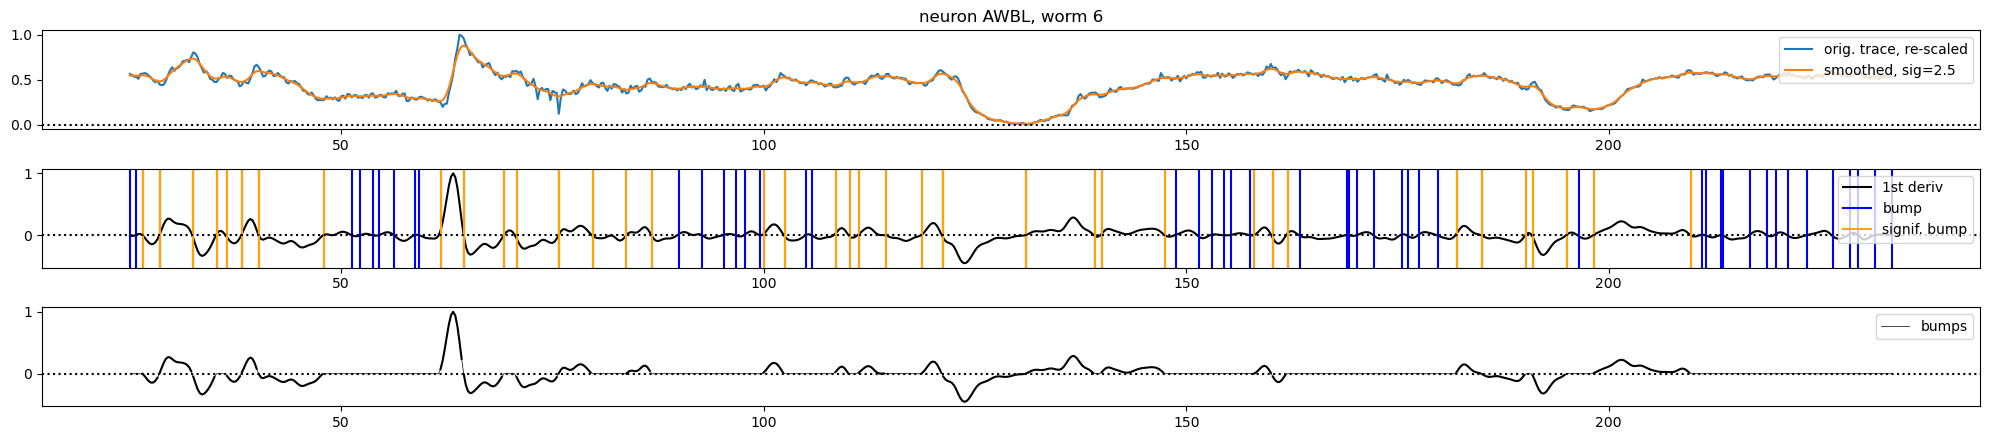

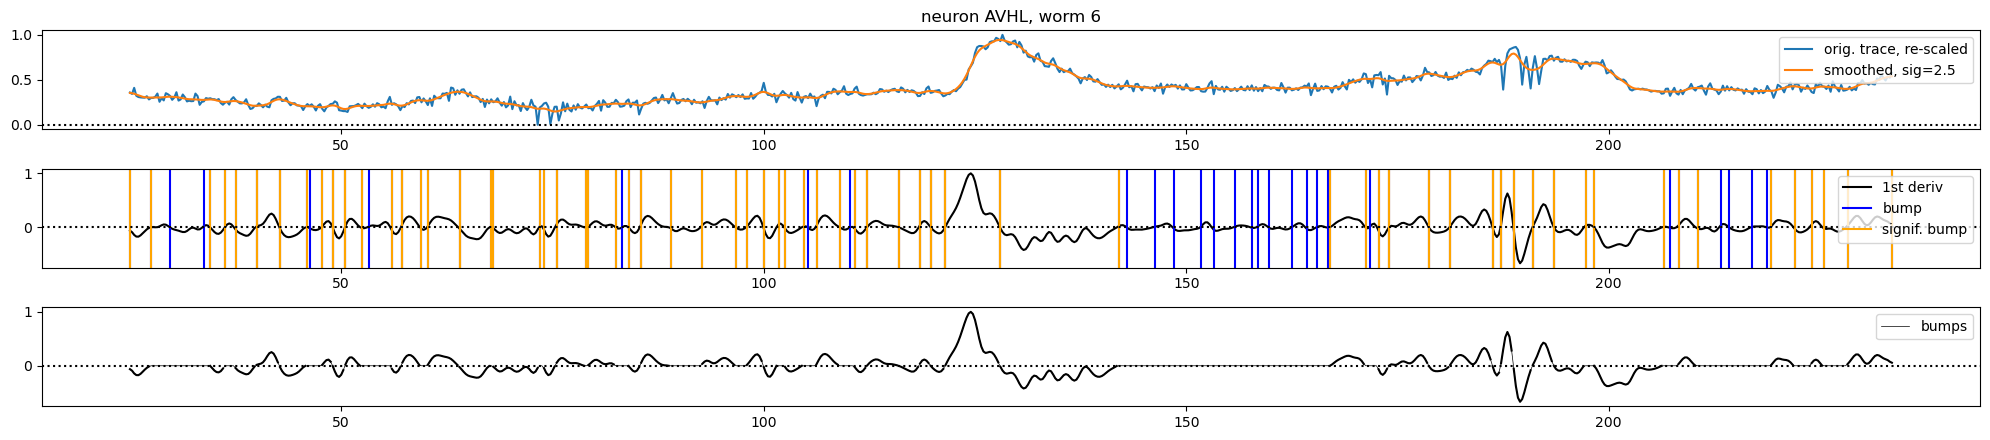

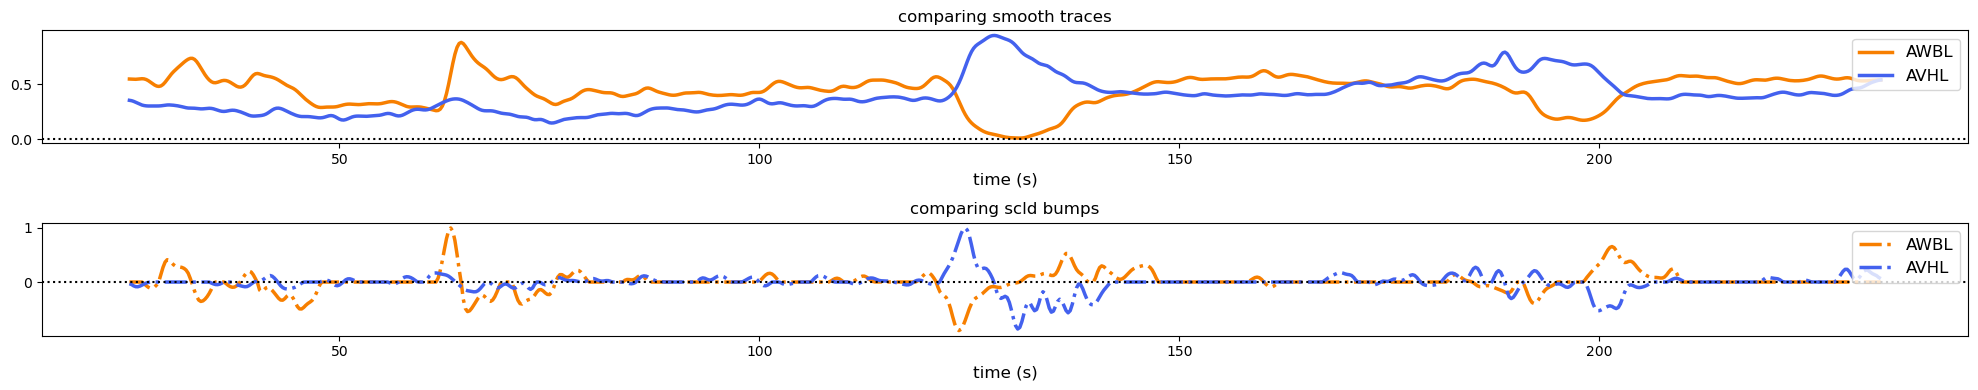

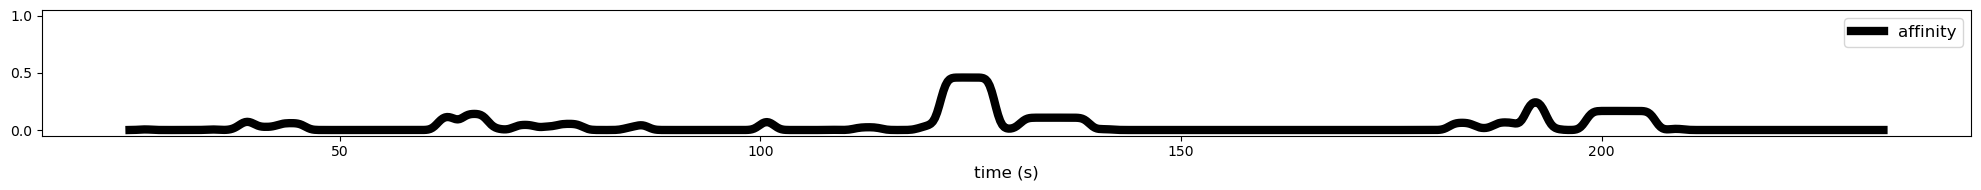

In [7]:

nnamei, nnamej = 'AWBL','AVHL'; wormi = 6 


smooth_sig = 2.5

plotAffinityComputation([nnamei, nnamej], wormi, smooth_sig, debug_simis=0, nonneg=True, 
               neuron_colors=['#F77F00','#4361EE'])


### building the tensor

In [8]:
#Gaussian smoothing of traces
smooth_sig = 2.5
time_pool_sz = 1 #subsample time axis, for speed? (set to 1 for no subsampling)
if time_pool_sz > 1:
    from skimage.measure import block_reduce



stim_seq_to_use = ('nacl', 'pentanedione', 'butanone')
worms_to_use = worm_groups[stim_seq_to_use]
tlen = int(np.ceil(raw_wormXs[worms_to_use[0]].shape[1]/time_pool_sz)) #total time length

In [9]:
method = 'both'
scaled_simis = 'trace'
nonneg = True



for wi,wormi in enumerate(worms_to_use):
    print(f'wormi {wi+1}/{len(worms_to_use)}',end=' ')
    
    #trace matrix for this worm
    origX = raw_wormXs[wormi]
    #scale to between 0-1
    sclr = MinMaxScaler()
    X = sclr.fit_transform(origX.T).T
    #smoothen it
    X = gaussian_filter1d(X,smooth_sig,axis=1)
    #deriv
    gX = np.gradient(X,axis=1)
    tlen = X.shape[1]
    
    
    crop = None

    wormA = np.zeros((tlen,N*(N-1)//2))
    
    cc = 0
    for ni in range(N):
        #update "progress bar"
        if ni % 5 == 0:
            print('.',end='')
            
        for nj in range(ni+1,N):
            
            try:
                wormA[:,cc], *_ = gradBumps(gX[ni], gX[nj], method, smooth_sig, 0.1, scaled_simis, 
                                        crop, t_is=X[[ni,nj]], nonneg=nonneg,smooth_simis=True)
            except:
                #if something goes wrong, printout current neurons and worm for debugging 
                print('worm',wormi,neuron_names[ni],neuron_names[nj])
                raise ValueError

            cc += 1
            
    if time_pool_sz > 1:
        wormA = block_reduce(wormA, (time_pool_sz,1), np.max) #subsample time axis using maxpool

    if wi == 0:
        T = wormA[None,...]
    else:
        T = np.concatenate([T,wormA[None,...]])

    print()

if nonneg:
    assert T.min() >= 0
T.shape

wormi 1/7 .........................
wormi 2/7 .........................
wormi 3/7 .........................
wormi 4/7 .........................
wormi 5/7 .........................
wormi 6/7 .........................
wormi 7/7 .........................


(7, 835, 7381)

### tensor decomposition

In [10]:
import tensortools as tt

n_components = 15

ensemble = tt.Ensemble(fit_method="ncp_hals")
ensemble.fit(T, ranks=range(n_components, n_components+1), replicates=5) #replicates sets how many differernt initializations to use



Rank-15 models:  min obj, 0.64;  max obj, 0.65;  time to fit, 157.3s


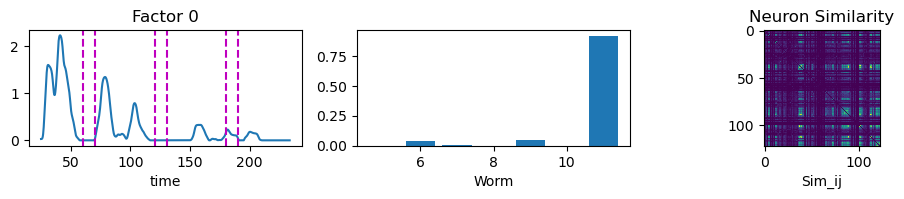

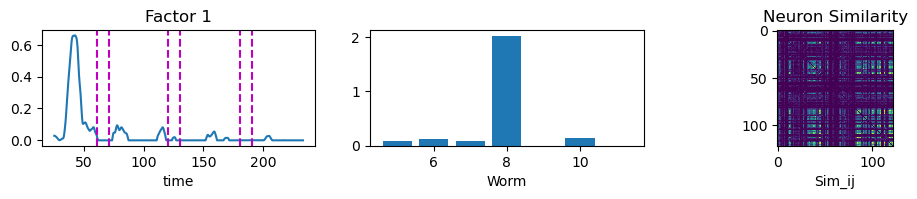

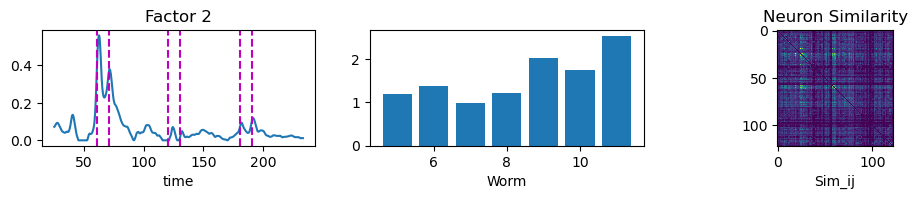

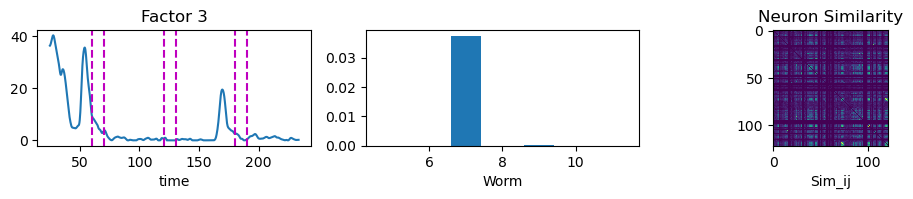

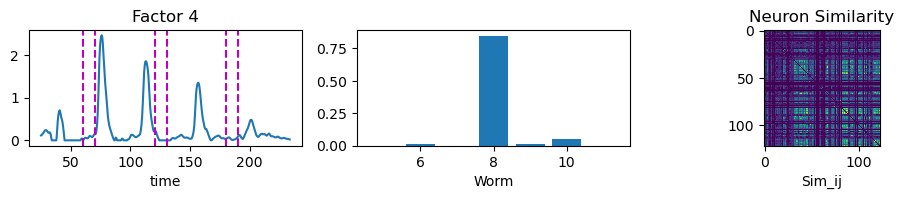

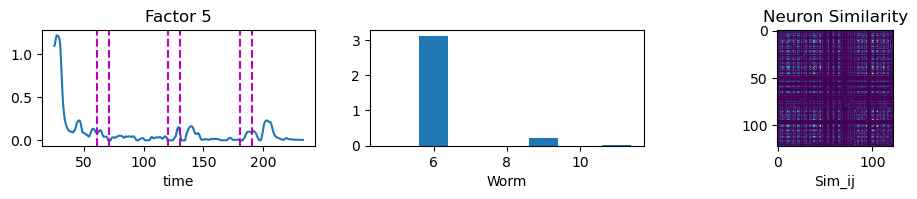

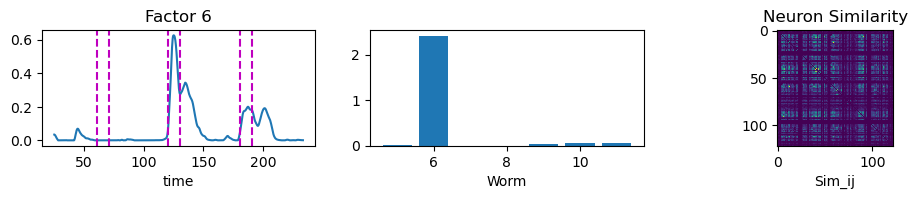

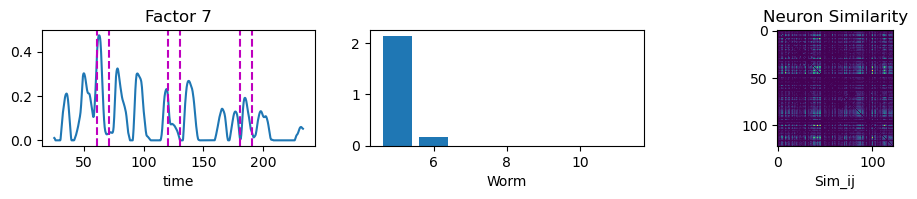

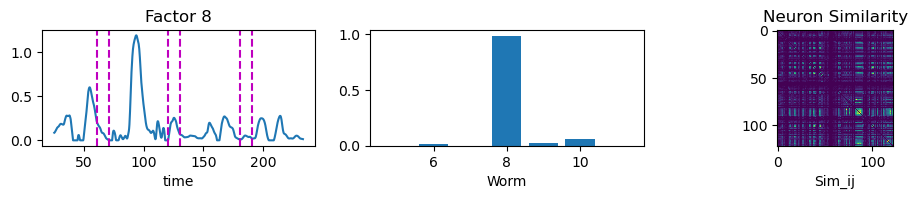

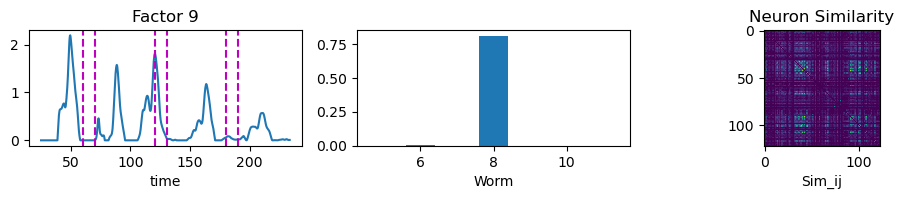

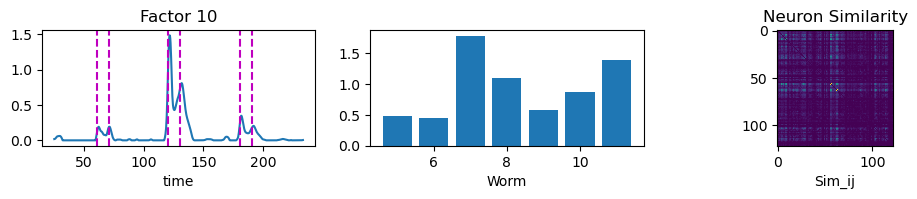

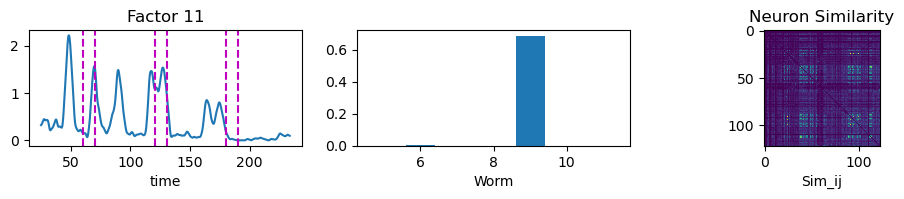

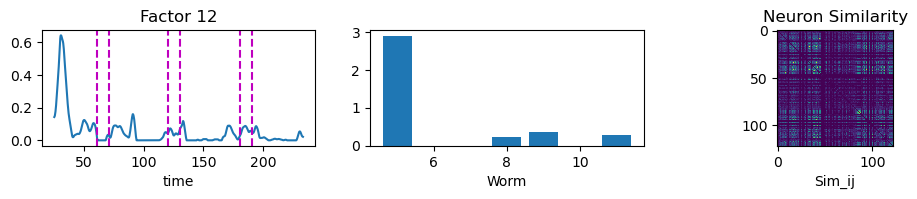

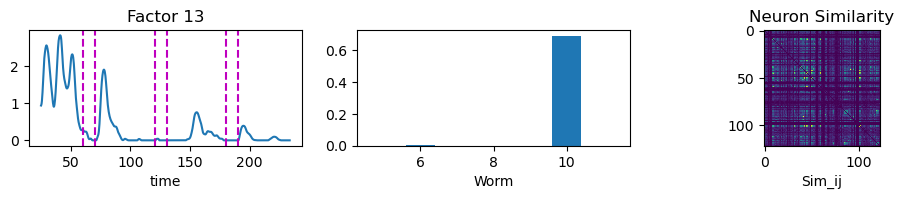

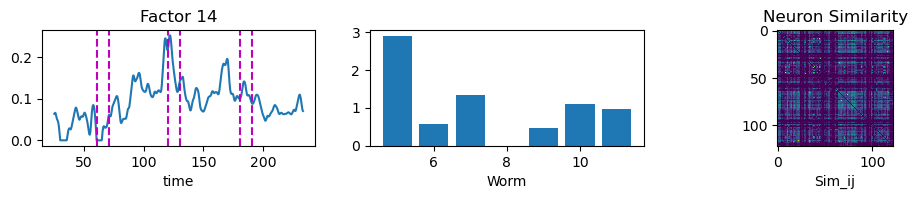

In [11]:
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

n_components = 15 #which n factors to show
best_factors = ensemble.factors(n_components)[0]

worm_factors, temporal_factors, simi_factors = best_factors

sorted_factors = np.arange(temporal_factors.shape[1])
ncols = 3; colsz = 4
nrows = n_components; rowsz = 1.5


for ll,l in enumerate(sorted_factors):
    
    fig,axes = plt.subplots(1,ncols,figsize=(colsz*ncols,rowsz))

    ax = axes[0]
    nf = temporal_factors[:,l]
    ax.set_title(f'Factor {l}')

    ts = actual_times[::time_pool_sz]
    stim_bounds = STIM_TIMES
    
    ax.plot(ts,nf)

    ax.set_xlabel('time')
    
    for s,e in stim_bounds:
        ax.axvline(s,color='m',ls='--')
        ax.axvline(e,color='m',ls='--')
    
    ax = axes[1]
    ax.bar(worms_to_use,worm_factors[:,l])
    ax.set(xlabel='Worm')
    ax = axes[2]

    pst = simi_factors[:,l]
    ax.imshow(squareform(pst),interpolation='nearest')
    ax.set_title('Neuron Similarity')
    ax.set_xlabel('Sim_ij')  
    
    plt.show()

### posthoc

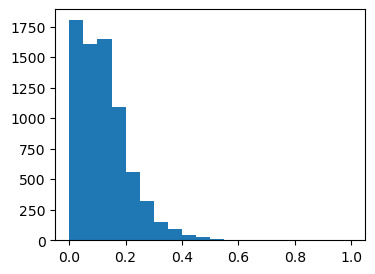

In [12]:
#CHOOSE FACTOR HERE
fi = 2

vals = simi_factors[:,fi].copy()
vals /= vals.max()

zs = vals
f,ax = subps(1,1)
ax.hist(zs,20);

In [13]:
zthresh = 0.1 #filter out really tiny edge weights to clean up visualization a bit (main communities dont change)
zssq = squareform(zs)
zssq_thresh = zssq.copy()
zssq_thresh[zssq_thresh < zthresh] = 0

#HERE, should check that all L-R pairs are included (one might be just below the threshold, f.ex.)
ni = 0
idxs_to_include = []
while ni < N:
    include = False
    l_max = zssq[ni].max()
    if l_max > zthresh:
        include = True

    nnamei = neuron_names[ni]
    if nnamei[-1] == 'L' and neuron_names[ni+1] == nnamei[:-1] + 'R':
        r_max = zssq[ni+1].max()
        if include and r_max < zthresh: #include R as well
            assert zssq_thresh[ni+1].max() == 0
            #add highest-weight connection
            zssq_thresh[ni+1,zssq[ni+1].argmax()] = r_max

        elif not include and r_max > zthresh: #include L as well
            zssq_thresh[ni,zssq[ni].argmax()] = l_max

        ni += 1
    ni += 1



In [14]:

factor_g = sp.sparse.csr_matrix(zssq_thresh)
#convert filtered graph into dense array
W = factor_g.A
W, log_neurons_used = remove_LR_pairs(W)


In [15]:
stim_to_use = f'w8-f{fi}'
worms_to_use = worm_groups[('nacl', 'pentanedione', 'butanone')]
pad = 5#padding around stimulus interval, in secs
STIM_LEN = np.diff(STIM_TIMES[[0]]).ravel()[0] #stimulus interval length, in secs
tlen = int(np.ceil((STIM_LEN + 2*pad)*FPS/time_pool_sz)) #total time length

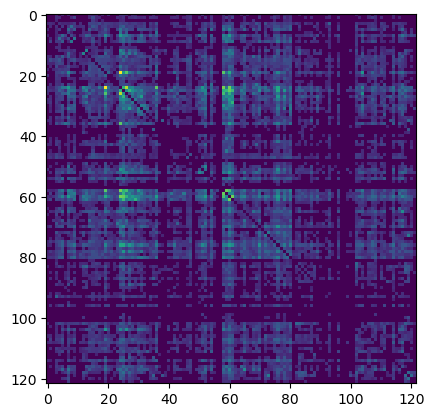

In [16]:
factor_g = sp.sparse.csr_matrix(zssq_thresh)
plt.imshow(factor_g.A)

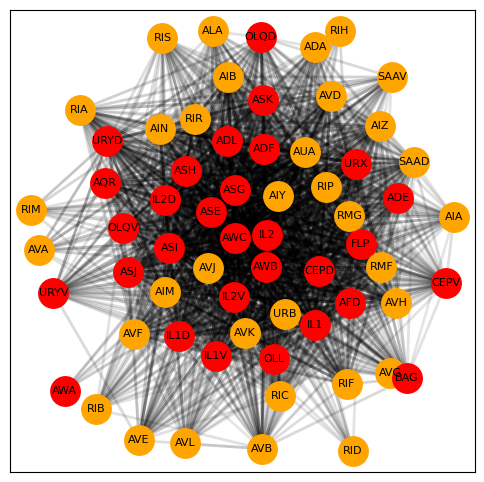

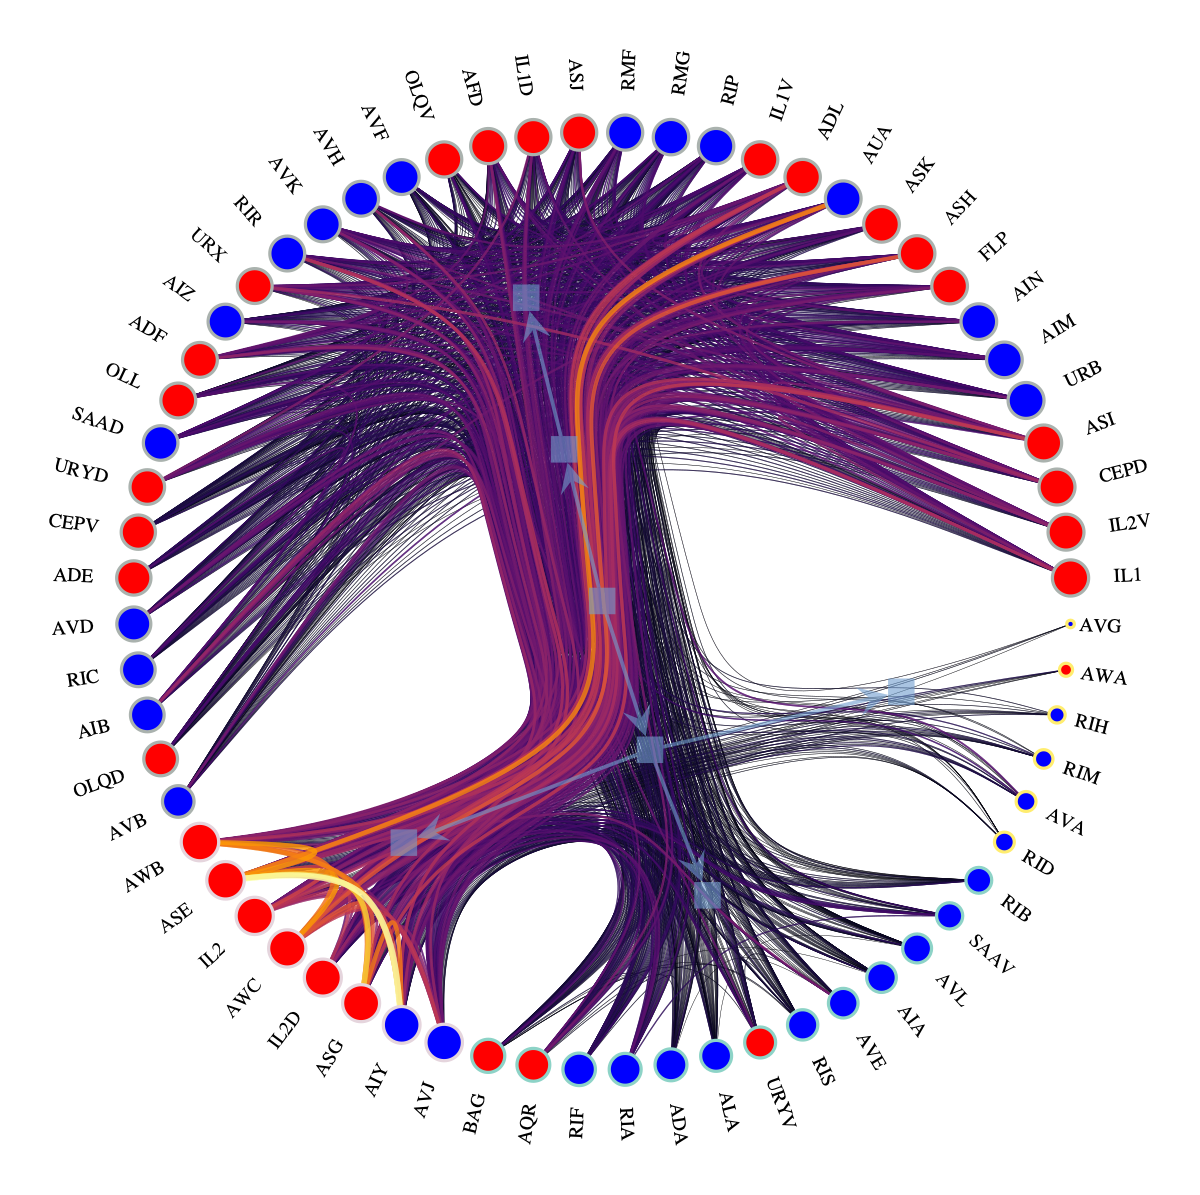

In [17]:
import graph_tool.all as gt
import matplotlib
import networkx as nx

LRexceptions = []

fixed_pos = False
noLR = True
deg_corr = True
remove_hierarchy_graph = False
vprop_pos = None

spring_layout = False

def removeLRsuffix(nname, exceptions=[]):
    if nname not in exceptions and nname in LR_pairs:
        assert nname[-1] == 'L' or nname[-1] == 'R'
        nname = nname[:-1]
    return nname


#convert filtered graph into dense array
W = factor_g.A

if noLR:
    W, _ = remove_LR_pairs(W, LRexceptions)

#filter out nodes with 0 weight
thresh = 0
nonzero_nodes = (W.max(1) > thresh)
W = W[nonzero_nodes][:,nonzero_nodes]
mynnames = np.array(neuron_names)[nonzero_nodes]
mynnames = [removeLRsuffix(nname,LRexceptions) for nname in mynnames]
mynclasses = np.array(neuron_classes)[nonzero_nodes]

G = nx.Graph(W)

pos = nx.spring_layout(G,seed=0,k=1.5)#
f,ax = subps(1,1,6,6)

node_sz = 450
edge_width = 2
edge_color = 'k'
node_colors = ['red','orange']
n = nonzero_nodes.sum()
#plot edges
for i in range(n):
    #plot nodes with alpha
    alpha = 1#W[i].mean()
    node_color = node_colors[mynclasses[i]]
    ax.scatter(*pos[i],s=node_sz,c=node_color,alpha=alpha,zorder=1)
    for j in range(i+1,n):
        ax.plot([pos[i][0],pos[j][0]], [pos[i][1],pos[j][1]], c=edge_color, lw=edge_width, alpha=W[i,j], zorder=0)

nx.draw_networkx_labels(G,pos,labels=dict(list(enumerate(mynnames))),font_size=8,); 
plt.show()



#get simi graph for this worm, from tensor
wadj = W
eps = 1e-10

#save graph to xml format, for loading with graph-tool
path = "tempG.xml"
nx.write_graphml_xml(G, path)
#load pre-saved xml graph
g = gt.load_graph(path)

#convert graph to undirected: mirror all its edges
g.set_directed(True)
m = g.edge_properties["weight"].a.size
edge_list = list(g.edges())
assert len(edge_list) == m
eprop_vals = np.zeros(m)
for ei0 in range(m):
    s,t = g.vertex_index[edge_list[ei0].source()], g.vertex_index[edge_list[ei0].target()]
    eprop_vals[ei0] = max(eps,wadj[s,t])
eprop = g.new_ep("double", vals = eprop_vals)
g.ep["worm_w"] = eprop
for ei0 in range(m):
    s,t = g.vertex_index[edge_list[ei0].source()], g.vertex_index[edge_list[ei0].target()]
    assert g.edge(t,s) is None#v-u not already in
    g.add_edge(g.vertex(t), g.vertex(s))
    g.edge_properties["weight"].a[m+ei0] = g.edge_properties["weight"].a[ei0]
    g.edge_properties["worm_w"].a[m+ei0] = g.edge_properties["worm_w"].a[ei0]
g.set_directed(False)

#set vertex labels (neuron names)
vprop = g.new_vertex_property("string")
for v in range(len(mynnames)):
    vprop[v] = mynnames[v]
g.vp["name"] = vprop

#sort verices by name within cluster
vprop = g.new_vertex_property("int")
for v,vi in enumerate(np.argsort(mynnames)):
    vprop[v] = vi
g.vp["vsorted"] = vprop

#set vertex colors (by neuron class)
vprop = g.new_vertex_property("string")
colors = ['red','blue','purple','green']
for v in range(len(mynnames)):
    vprop[v] = colors[mynclasses[v]]
g.vp["color"] = vprop



np.random.seed(42)
gt.seed_rng(42)

# https://graph-tool.skewed.de/static/doc/demos/inference/inference.html#edge-weights-and-covariates
state = gt.minimize_nested_blockmodel_dl(g, state_args=dict(deg_corr=deg_corr,recs=[g.ep.weight],rec_types=["real-exponential"]))

# improve solution with merge-split
for i in range(100):
    ret = state.multiflip_mcmc_sweep(niter=10, beta=np.inf)

if remove_hierarchy_graph:
    hvprops, heprops = {'fill_color':[0., 0., 0., 0.]}, {'color':[0., 0., 0., 0.]}
else:
    hvprops, heprops = None, None

if spring_layout:
    #save figure as pdf, with spring-block layout
    state.draw(layout='sfdp',edge_color=g.ep.worm_w, ecmap=(matplotlib.cm.inferno, .6), rel_order=g.vp.vsorted, hvprops=hvprops,
                   eorder=g.ep.worm_w, edge_pen_width=gt.prop_to_size(g.ep.worm_w, .2, 3, power=1), heprops=heprops,
                   edge_gradient=[],vertex_text=g.vp.name, vertex_text_position='centered', vertex_fill_color=g.vp.color)
else:
    #save figure as pdf, with radial layout
    _, myt, mytpos = state.draw(pos=vprop_pos, edge_color=g.ep.worm_w, ecmap=(matplotlib.cm.inferno, .6), hvprops=hvprops,
                   eorder=g.ep.worm_w, edge_pen_width=gt.prop_to_size(g.ep.worm_w, .2, 3, power=1), heprops=heprops,
                   edge_gradient=[],vertex_text=g.vp.name, vertex_text_position='centered', vertex_fill_color=g.vp.color)



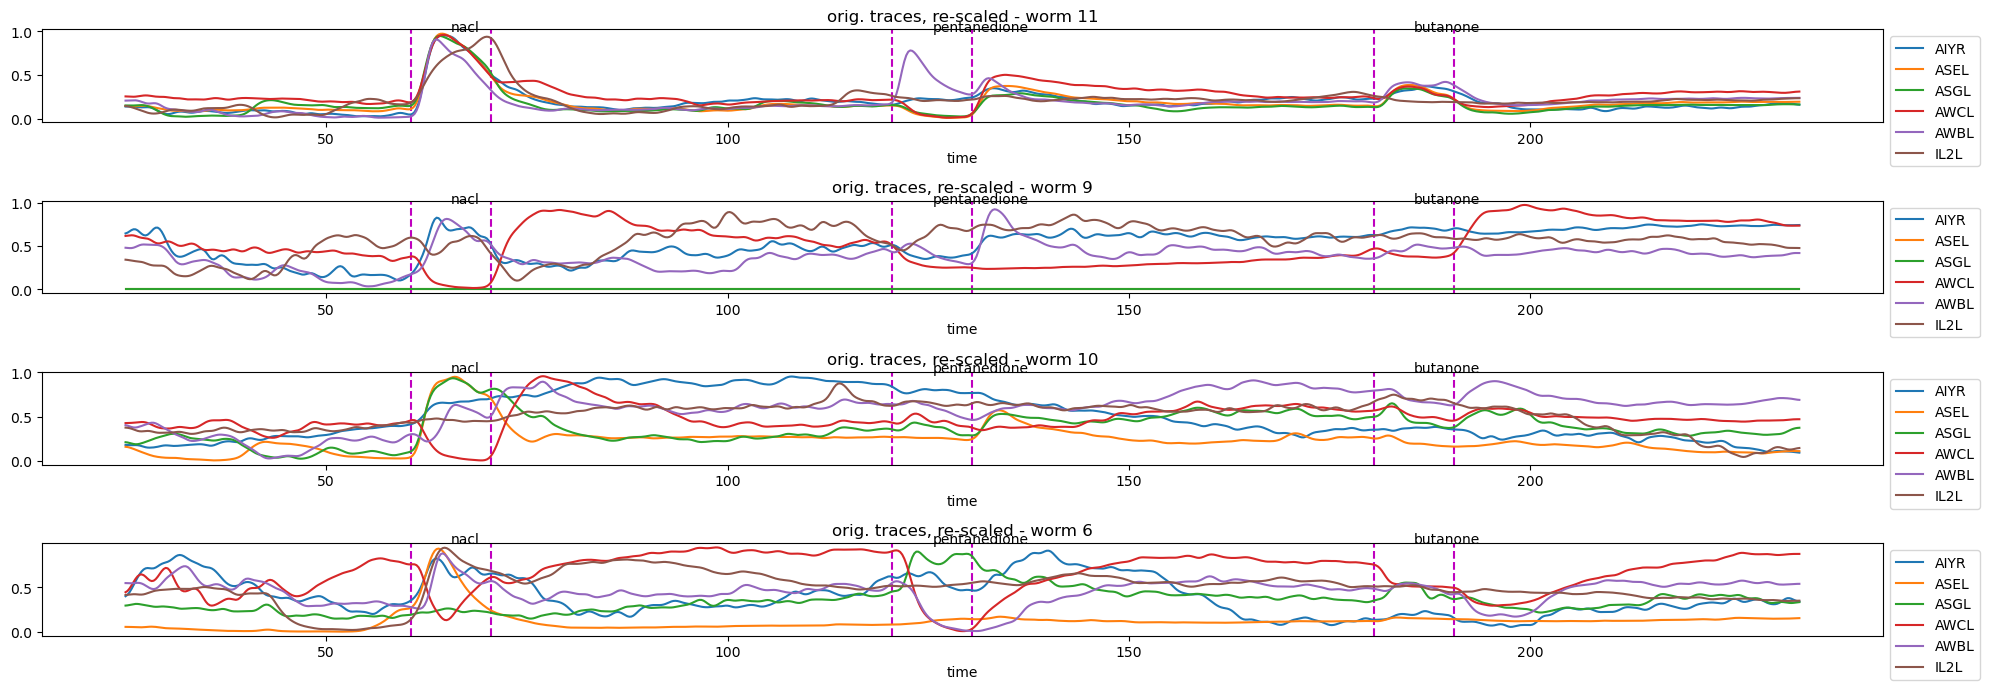

In [18]:
plotMultipleTraces(['AIYR', 'ASEL', 'ASGL', 'AWCL', 'AWBL', 'IL2L'],[11,9,10,6],smooth_sig=2.5)

/var/folders/4j/8xwqp3td6vx1l3cds5jkdzr00000gn/T/ipykernel_70049/349073221.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']*len(ax.get_xticks()))


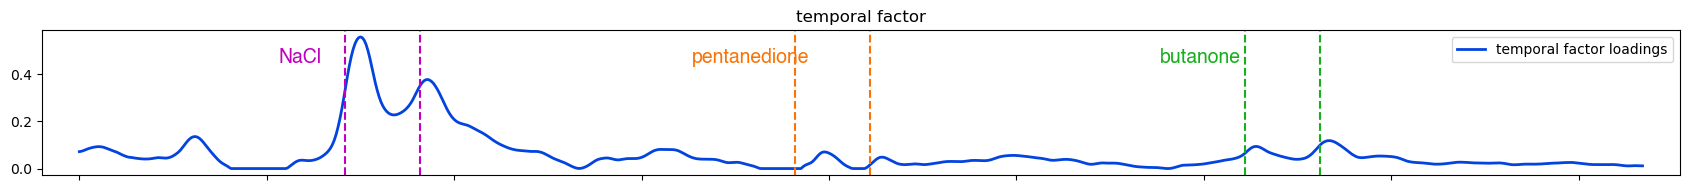

In [19]:
f,ax = subps(1,1,2,17)
ax.plot(actual_times,temporal_factors[:,fi],c='xkcd:blue',lw=2,label='temporal factor loadings')
ax.legend(bbox_to_anchor=(1,1))
# ax.set_xlabel('time (s)')
ax.set_xticklabels(['']*len(ax.get_xticks()))
wormi = 11
STIM_NAMES = 'butanone', 'pentanedione', 'NaCl'
stimcolors = ['m','xkcd:orange','xkcd:green']
for stimi,(s,e) in enumerate(STIM_TIMES):
    ax.axvline(s,color=stimcolors[stimi],ls='--')
    ax.axvline(e,color=stimcolors[stimi],ls='--')
    ax.text(s-1.2*(e-s)/2,max(temporal_factors[:,fi])*.8,
            STIM_NAMES[head_data['stims'][wormi][stimi]-1],
            ha='center',size=14,fontdict={'family':'helvetica'},color=stimcolors[stimi])
ax.set_xlim(actual_times[0]-5,actual_times[-1]+5)
ax.set_title('temporal factor')
f.tight_layout()
plt.show()

/var/folders/4j/8xwqp3td6vx1l3cds5jkdzr00000gn/T/ipykernel_70049/3600094305.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']*len(ax.get_xticks()))


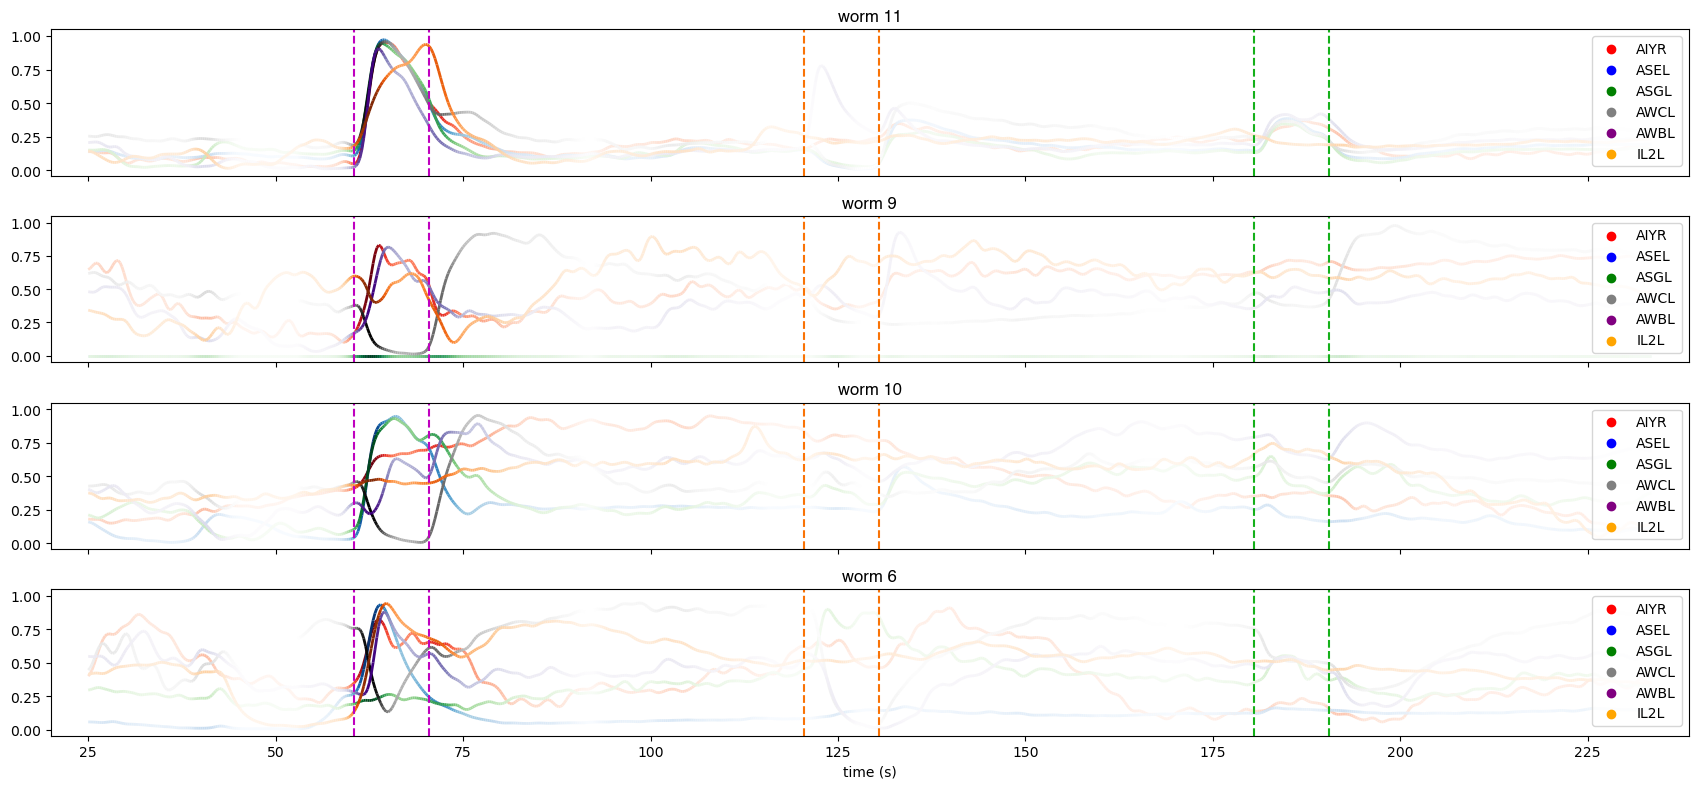

In [20]:
nnames = ['AIYR', 'ASEL', 'ASGL', 'AWCL', 'AWBL', 'IL2L']
wormis = [11,9,10,6]
smooth_sig=2.5
alphas = None
alphas = np.repeat(temporal_factors[:,fi],time_pool_sz)
# alphas += .5
alphas /= alphas.max()
alphas *= .7
#alphas = np.r_[np.zeros(global_left_trim),alphas]
from matplotlib.collections import LineCollection

f,axes = subps(len(wormis),1,2,17,axlist=1)
cmaps = ['Reds','Blues','Greens','Greys','Purples','Oranges']
colors = ['r','b','g','gray','purple','orange']
for wi,wormi in enumerate(wormis):
    ax = axes[wi]
    ax.set_title(f'worm {wormi}',fontdict={'family':'helvetica'},size=12)

    

    ax.set_xlim(actual_times[0]-5,actual_times[-1]+5)

    for ii,nname in enumerate(nnames):

        ni = neuron_names.index(nname)
        orig_trace_i = raw_wormXs[wormi][ni].copy()

        orig_trace_i -= orig_trace_i.min()
        if orig_trace_i.max() > 0:
            orig_trace_i /= orig_trace_i.max()

        if smooth_sig is not None and smooth_sig > 0:
            trace_i = gaussian_filter1d(orig_trace_i,smooth_sig)
        else:
            trace_i = orig_trace_i

        x = actual_times
        y = trace_i

        if alphas is not None:

            points = np.vstack((x, y)).T.reshape(-1, 1, 2)
            segments = np.hstack((points[:-1], points[1:]))
            lc = LineCollection(segments, array=alphas, cmap=cmaps[ii], lw=2)#, label=nname)
            ax.scatter([0],[1],c=colors[ii],label=nname)
            line = ax.add_collection(lc)
            ax.autoscale()            
        else:
            ax.plot(actual_times,trace_i,label=nname)
    STIM_NAMES = 'butanone', 'pentanedione', 'NaCl'
    stimcolors = ['m','xkcd:orange','xkcd:green']
    for stimi,(s,e) in enumerate(STIM_TIMES):
        ax.axvline(s,color=stimcolors[stimi],ls='--')
        ax.axvline(e,color=stimcolors[stimi],ls='--')
#         ax.text(s-(e-s)/2,.8,
#                 STIM_NAMES[head_data['stims'][wormi][stimi]-1],
#                 ha='center',size=14,fontdict={'family':'helvetica'},color=stimcolors[stimi])
    ax.set_xlim(actual_times[0]-5,actual_times[-1]+5)
    ax.legend(bbox_to_anchor=(1,1))
    if wi < len(wormis)-1:
        ax.set_xticklabels(['']*len(ax.get_xticks()))
    else:
        ax.set_xlabel('time (s)')


f.tight_layout()
plt.show()

/var/folders/4j/8xwqp3td6vx1l3cds5jkdzr00000gn/T/ipykernel_70049/915787232.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']*len(ax.get_xticks()))


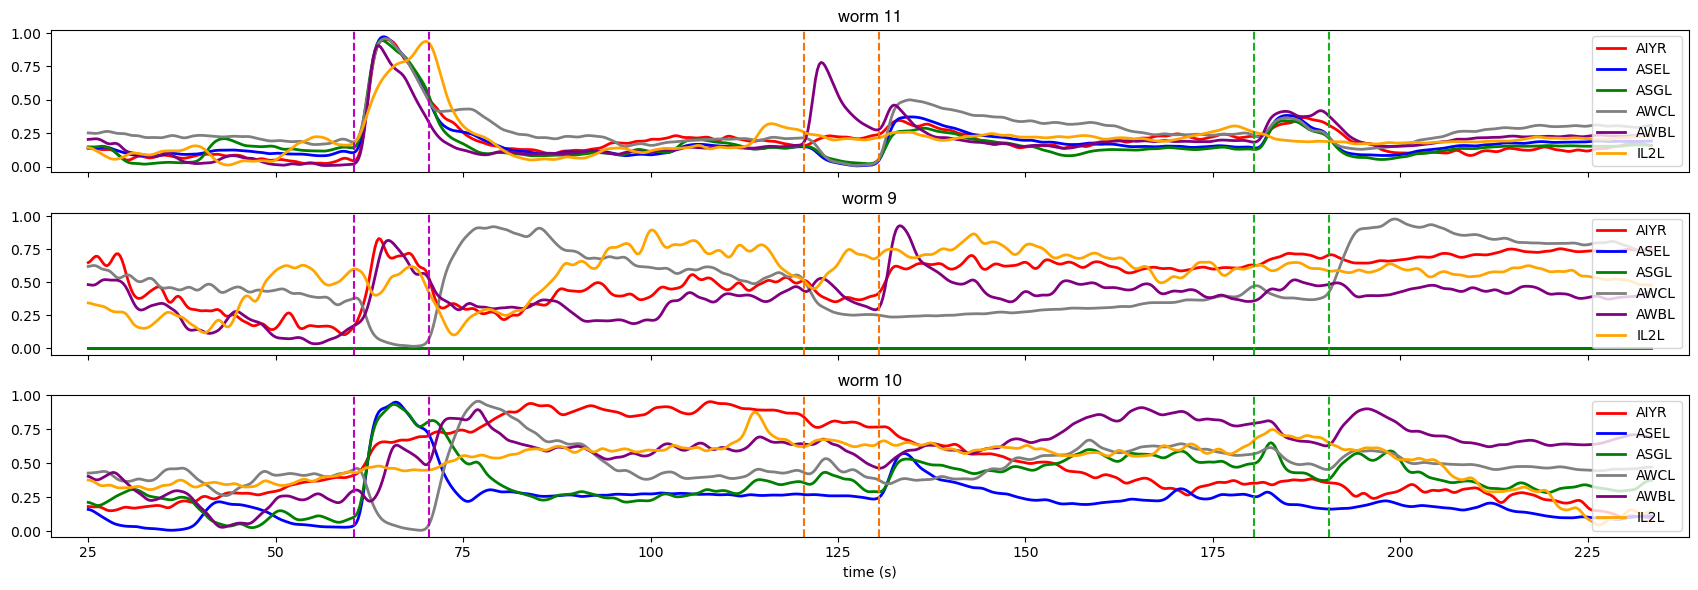

In [21]:
nnames = ['AIYR', 'ASEL', 'ASGL', 'AWCL', 'AWBL', 'IL2L']
wormis = [11,9,10]
smooth_sig=2.5
alphas = None

from matplotlib.collections import LineCollection

f,axes = subps(len(wormis),1,2,17,axlist=1)
cmaps = ['Reds','Blues','Greens','Greys','Purples','Oranges']
colors = ['r','b','g','gray','purple','orange']
for wi,wormi in enumerate(wormis):
    ax = axes[wi]
    ax.set_title(f'worm {wormi}',fontdict={'family':'helvetica'},size=12)

    

    ax.set_xlim(actual_times[0]-5,actual_times[-1]+5)

    for ii,nname in enumerate(nnames):

        ni = neuron_names.index(nname)
        orig_trace_i = raw_wormXs[wormi][ni].copy()

        orig_trace_i -= orig_trace_i.min()
        if orig_trace_i.max() > 0:
            orig_trace_i /= orig_trace_i.max()

        if smooth_sig is not None and smooth_sig > 0:
            trace_i = gaussian_filter1d(orig_trace_i,smooth_sig)
        else:
            trace_i = orig_trace_i

        x = actual_times
        y = trace_i

        if alphas is not None:

            points = np.vstack((x, y)).T.reshape(-1, 1, 2)
            segments = np.hstack((points[:-1], points[1:]))
            lc = LineCollection(segments, array=alphas, cmap=cmaps[ii], lw=2)#, label=nname)
            ax.scatter([0],[1],c=colors[ii],label=nname)
            line = ax.add_collection(lc)
            ax.autoscale()            
        else:
            ax.plot(actual_times,trace_i,c=colors[ii],lw=2,label=nname)
    STIM_NAMES = 'butanone', 'pentanedione', 'NaCl'
    stimcolors = ['m','xkcd:orange','xkcd:green']
    for stimi,(s,e) in enumerate(STIM_TIMES):
        ax.axvline(s,color=stimcolors[stimi],ls='--')
        ax.axvline(e,color=stimcolors[stimi],ls='--')
#         ax.text(s-(e-s)/2,.8,
#                 STIM_NAMES[head_data['stims'][wormi][stimi]-1],
#                 ha='center',size=14,fontdict={'family':'helvetica'},color=stimcolors[stimi])
    ax.set_xlim(actual_times[0]-5,actual_times[-1]+5)
    ax.legend(loc='center right')#bbox_to_anchor=(1,1))
    if wi < len(wormis)-1:
        ax.set_xticklabels(['']*len(ax.get_xticks()))
    else:
        ax.set_xlabel('time (s)')


f.tight_layout()
plt.show()